In [16]:
from tianshou.policy import PPOPolicy
!jupyter nbconvert --to script pack_existing_segs.ipynb

[NbConvertApp] Converting notebook pack_existing_segs.ipynb to script
[NbConvertApp] Writing 1722 bytes to pack_existing_segs.py


In [17]:
import uuid
from tianshou.utils import WandbLogger, LazyLogger
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import TimeLimit
from customs import custom_offpolicy_trainer, CustomDQNPolicy, CustomOffpolicyTrainer
from dataset import *
from env import *
from networks.q_network import *
from tianshou.utils.net.common import ActorCritic
from tianshou.utils.net.discrete import Actor, Critic, IntrinsicCuriosityModule
from tianshou.trainer import OnpolicyTrainer
%matplotlib inline

In [18]:
# if username is server use cuda
if os.environ['USER'] == 'server':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# if __name__ == '__main__':
#     torch.multiprocessing.set_start_method('spawn')

In [19]:
def get_wandb(use_wandb):
    if use_wandb:
        wandb_logger = WandbLogger(
            train_interval=1,
            test_interval=1,
            update_interval=1,
            project="AttentionRL",
        )
        wandb_logger.load(SummaryWriter("./logs"))
    else:
        wandb_logger = LazyLogger()

    return wandb_logger

In [20]:
def get_train_fn(policy, eps_train, inital_phase):
    def train_fn(epoch, env_step):
        policy.set_eps(eps_train[epoch - 1])
        if epoch >= inital_phase:
            for param in policy.model.vit_trail_encoder.parameters():
                param.requires_grad = True

        if epoch >= 0 and epoch % 50 == 0:
            torch.save(policy.state_dict(), f'saved/policy_{wandb_logger.wandb_run.name if use_wandb else uuid.uuid4().hex}.pt')

        wandb_logger.write('train', trainer.env_step, {"epoch": epoch})
    return train_fn

In [21]:
def register_hooks(model):
    hook0 = model.dueling_head.Q.model[-1].register_forward_hook(lambda self, input, output: print(f"Q: {output}"))
    hook1 = model.dueling_head.V.model[-1].register_forward_hook(lambda self, input, output: print(f"V: {output}"))
    # hook2 = model.dueling_head.model.model[0].register_forward_hook(lambda self, input, output: print(f"net: {output}"))

def get_DQN_policy():
    config.update({
        "n_step": 1,
        "target_freq": 1200,
    })

    action_count = len(Actions)
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=config['lr'])
    policy = CustomDQNPolicy(net, optim, discount_factor=config['gamma'], estimation_step=config['n_step'], target_update_freq=config['target_freq'], polyak=None)
    # register_hooks(policy.model)
    return policy

def get_PPO_policy():
    config.update({
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "vf_coef": 0.25,
        "ent_coef": 0.01,
        "rew_norm": True,
        "eps_clip": 0.1,
        "value_clip": 1,
        "dual_clip": None,
        "norm_adv": True,
        "recompute_adv": 0,
    })

    action_count = len(Actions)
    base_net = ViTTrailEncoder()
    actor = Actor(base_net, action_count, device=device, softmax_output=False)
    critic = Critic(base_net, device=device)
    optim = torch.optim.Adam(
        ActorCritic(actor, critic).parameters(), lr=config['lr'], eps=1e-5
    )
    def dist(p):
        return torch.distributions.Categorical(logits=p)
    policy = PPOPolicy(
        actor,
        critic,
        optim,
        dist,
        discount_factor=config['gamma'],
        gae_lambda=config['gae_lambda'],
        max_grad_norm=config['max_grad_norm'],
        vf_coef=config['vf_coef'],
        ent_coef=config['ent_coef'],
        reward_normalization=config['rew_norm'],
        action_scaling=False,
        eps_clip=config['eps_clip'],
        value_clip=config['value_clip'],
        dual_clip=config['dual_clip'],
        advantage_normalization=config['norm_adv'],
        recompute_advantage=config['recompute_adv'],
    ).to(device)
    return policy

In [22]:
def get_offpolicy_trainer():
    replay_buffer = ts.data.VectorReplayBuffer(config['buffer_size'], len(config['train_envs']))
    train_collector = ts.data.Collector(policy, config['train_envs'], replay_buffer, exploration_noise=True)

    config['update_per_step'] = 1 / config['step_per_collect'] * 4
    trainer = CustomOffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=None,
        episode_per_test=config['test_num'],
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        step_per_collect=config['step_per_collect'],
        batch_size=config['batch_size'],
        update_per_step=config['update_per_step'],
        train_fn=get_train_fn(policy, config['eps_train'], config['initial_phase']),
        test_fn=lambda epoch, env_step: policy.set_eps(config['eps_test']),
        logger= wandb_logger,
    )
    return trainer

def get_onpolicy_trainer():
    replay_buffer = ts.data.VectorReplayBuffer(
        config['buffer_size'],
        len(config['train_envs']),
    )
    train_collector = ts.data.Collector(policy, config['train_envs'], replay_buffer, exploration_noise=True)

    config.update({
        'repeat_per_collect': 4,
    })

    trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=None,
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        repeat_per_collect=config['repeat_per_collect'],
        batch_size=config['batch_size'],
        step_per_collect=config['step_per_collect'],
        logger=wandb_logger,
    )

    return trainer

In [23]:
if __name__ == "__main__": ########Policy Initialization########
    use_wandb = False
    wandb_logger = get_wandb(use_wandb)

    config = {
        "lr": 8e-5,
        "epoch": 2000,
        "batch_size": 20,
        "initial_phase": 0,
        "test_num": 10,
        "gamma": 0.98,
        "buffer_size": 20000,
        "eps_start": 0.9,
        "eps_end": 0.05,
        "step_per_epoch": 2000,
        "step_per_collect": 100,
        "env_step_limit": 100,
        "eps_train": np.linspace(0.9, 0.05, 2000),
        "eps_test": 0,
    }

    dataset = COCODataset(train=True, indices=[12], no_seg=True)
    # train_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataset, (32, 32)), 5) for _ in range(1)])
    train_envs = ts.env.DummyVectorEnv(
        [lambda: TimeLimit(Environment(dataset, (32, 32)), config['env_step_limit']) for _ in range(1)])
    config['train_envs'] = train_envs

    policy = get_DQN_policy()
    # policy = get_PPO_policy()

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['embeddings.mask_token', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# policy.load_state_dict(torch.load('saved/policy_whole-durian-46.pt'))

In [25]:
if __name__ == "__main__": ########Training########
    trainer = get_offpolicy_trainer()
    # trainer = get_onpolicy_trainer()

    if use_wandb:
        wandb_logger.wandb_run.config.update(config)
    trainer.run()

Epoch #1:  15%|##############4                                                                                 | 300/2000 [00:11<01:03, 26.69it/s, env_step=200, len=100, loss=0.523, n/ep=1, n/st=100, rew=-61.00]


KeyboardInterrupt: 

In [ ]:
# if __name__ == "__main__":
#     env = TimeLimit(Environment(dataset, (32, 32)), 200)
#     ut.show_masks_on_image(einops.rearrange(env.current_image, 'c h w -> h w c'), env.current_seg.cpu().numpy())
#     plt.show()


KeyboardInterrupt



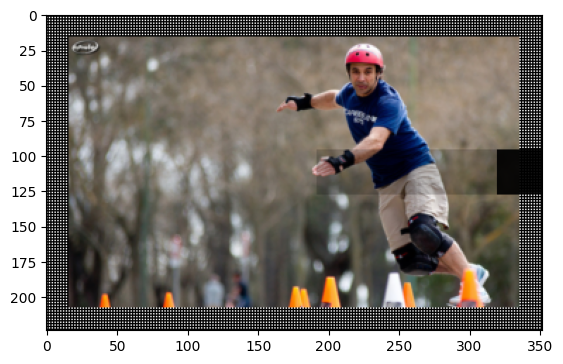

In [26]:
if __name__ == "__main__":
    # dataset = COCODataset(root="../Data/COCO17", train=True, len=1)
    policy.eval()
    policy.set_eps(config['eps_test'])
    dataset = COCODataset(train=True, indices=[12], no_seg=True)
    env = TimeLimit(Environment(dataset, (32, 32)), 100)
    collector = ts.data.Collector(policy, env, exploration_noise=True)
    collector.collect(n_episode=1, render=1/10)
    # collector.collect(n_episode=1)